In [2]:
# Load Libraries
import numpy as np # linear algebra
import pandas as pd # dataframes
import matplotlib.pyplot as plt # General visualisations
import matplotlib.ticker as mtick # Axis visuals
import seaborn as sns # Statistical visualisations
import statsmodels.api as sm # Linear Regression

# 1. Data Loading

In [17]:
# load data into pandas dataframe
df_customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
df_orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
df_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")
df_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
df_products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
df_reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
df_sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")
df_categories = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')


In [18]:
dfs = {
    'customers': df_customers,
    'orders': df_orders,
    'payments': df_payments,
    'items': df_items,
    'products':df_products,
    'reviews':df_reviews,
    'sellers':df_sellers,
    'categories': df_categories
}

In [19]:
# show data shapes of each dataset and missing value 
for ds, df in dfs.items():
    print('{}: {} x {}'.format(ds,df.shape[0], df.shape[1]))
    print(df.isnull().sum()/df.count()*100)
    print('\n')
print('\n')

customers: 99441 x 5
customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64


orders: 99441 x 8
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.161159
order_delivered_carrier_date     1.825759
order_delivered_customer_date    3.073303
order_estimated_delivery_date    0.000000
dtype: float64


payments: 103886 x 5
order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64


items: 112650 x 7
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64


products: 32951 x 9
product_i

# 2. Preparing Data

## 2.1 order level aggregation

In [276]:
# Merge order level data into one dataframe

# Left join with payments data (1 to 1)
dfm_orders = pd.merge(dfs['orders'], dfs['payments'],on="order_id",how="left")\
    .loc[:, ['customer_id', 'order_id','order_purchase_timestamp', 'payment_type','payment_value']]

# Left join with items data ( 1 to N)
dfm_orders = dfm_orders.merge(dfs['items'],on="order_id",how="left")\
    .loc[:, dfm_orders.columns.to_list() + ['order_item_id','product_id','seller_id', 'price', 'freight_value']]

# Left join with products data ( 1 to 1)
dfm_orders = dfm_orders.merge(dfs['products'],on="product_id",how="left")\
    .loc[:, dfm_orders.columns.to_list() + ['product_category_name']]

# Left join with products data ( 1 to 1)
dfm_orders = dfm_orders.merge(dfs['categories'],on="product_category_name",how="left")\
    .loc[:, dfm_orders.columns.to_list() + ['product_category_name_english']]

# add derived purchase date info (year, month also available)
dfm_orders.insert(dfm_orders.shape[1],
                    'order_purchase_date',
                    pd.to_datetime(dfm_orders.order_purchase_timestamp).dt.date
                   )

In [277]:
dfm_orders.shape

(118434, 13)

In [278]:
# check missing data
dfm_orders.isnull().sum()

customer_id                         0
order_id                            0
order_purchase_timestamp            0
payment_type                        3
payment_value                       3
order_item_id                     830
product_id                        830
seller_id                         830
price                             830
freight_value                     830
product_category_name            2528
product_category_name_english    2553
order_purchase_date                 0
dtype: int64

In [23]:
# debug only
dfm_orders.groupby('payment_type').size()

payment_type
boleto         23037
credit_card    87286
debit_card      1698
not_defined        3
voucher         6407
dtype: int64

In [ ]:
# debug only
dfm_orders[dfm_orders.order_purchase_date.isnull()]

In [13]:
#debug only
dfm_orders.dtypes

customer_id                  object
order_id                     object
order_purchase_timestamp     object
payment_type                 object
payment_value               float64
order_item_id               float64
product_id                   object
seller_id                    object
price                       float64
freight_value               float64
product_category_name        object
order_purchase_date          object
dtype: object

In [280]:
# fill missing data of payment_value
dfm_orders['payment_value'] = np.where(dfm_orders.payment_value.isnull(),dfm_orders.price+dfm_orders.freight_value, dfm_orders.payment_value)
dfm_orders['payment_type'] = np.where(dfm_orders.payment_type.isnull(),'credit_card',dfm_orders.payment_type)
dfm_orders['price'] = np.where(dfm_orders.price.isnull(),dfm_orders.payment_value, dfm_orders.price)
dfm_orders['freight_value'] = np.where(dfm_orders.freight_value.isnull(),0, dfm_orders.freight_value)
dfm_orders['product_category_name'] = np.where(dfm_orders.product_category_name.isnull(),'',dfm_orders.product_category_name)
dfm_orders['product_category_name_english'] = np.where(dfm_orders.product_category_name_english.isnull(),dfm_orders.product_category_name,dfm_orders.product_category_name_english)
dfm_orders['order_item_id'] = np.where(dfm_orders.order_item_id.isnull(),0,dfm_orders.order_item_id)

In [281]:
agg_order = dfm_orders.groupby('order_id').agg({
 'customer_id':'max',
 'payment_value':'sum',
 'price':'sum',
 'freight_value':'sum',
 'order_item_id':'count',
 'product_category_name': lambda x: set(x),
 'product_category_name_english':lambda x: set(x),
 'payment_type': lambda x: set(x),
}).reset_index().rename(columns={
 'customer_id':'customer_id',
 'payment_value':'spend',
 'price':'price',
 'freight_value':'shipping_fee',
 'order_item_id':'basket_size',
 'product_category_name': 'product_categories',
 'product_category_name_english': 'product_categories_en',
 'payment_type': 'payment_types'
})

In [282]:
agg_order.head()

,order_id,customer_id,spend,price,shipping_fee,basket_size,product_categories,product_categories_en,payment_types
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,72.19,58.90,13.29,1,{cool_stuff},{cool_stuff},{credit_card}
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,259.83,239.90,19.93,1,{pet_shop},{pet_shop},{credit_card}
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,216.87,199.00,17.87,1,{moveis_decoracao},{furniture_decor},{credit_card}
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,25.78,12.99,12.79,1,{perfumaria},{perfumery},{credit_card}
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,218.04,199.90,18.14,1,{ferramentas_jardim},{garden_tools},{credit_card}


In [283]:
# convert set to string
#agg_order.drop(columns=['payment_type_set','product_cat_set'])
agg_order['payment_types'] = agg_order['payment_types'].apply(lambda x: ','.join(x))
agg_order['product_categories'] = agg_order['product_categories'].apply(lambda x: ','.join(x))
agg_order['product_categories_en'] = agg_order['product_categories_en'].apply(lambda x: ','.join(x))

In [284]:
agg_order.groupby('product_categories_en').size()

product_categories_en
                                     2185
,auto                                   1
,baby,bed_bath_table                    1
,bed_bath_table                         6
,books_imported                         1
                                     ... 
watches_gifts,musical_instruments       1
watches_gifts,perfumery                 1
watches_gifts,sports_leisure            5
watches_gifts,telephony                 2
watches_gifts,toys                      1
Length: 344, dtype: int64

In [ ]:
agg_order.groupby('payment_types').size()

In [ ]:
agg_order.head()

## 2.2 build customer level modellig dataset

In [285]:
# aggregation at customer level
dfm_customer = pd.merge(agg_order, dfs['customers'], on='customer_id',how='inner')\
    .loc[:,agg_order.columns.to_list() + ['customer_unique_id','customer_state']]

agg_customer = dfm_customer.groupby('customer_unique_id').agg({
    'order_id':'count',
    'spend':'sum',
    'basket_size':'sum',
    'product_categories': lambda x: set(x),
    'product_categories_en': lambda x: set(x),
    'payment_types': lambda x: set(x)
    
}).reset_index().rename(columns={
    'order_id':'orders',
    'spend':'total_spend',
    'basket_size':'basket_size',
    'product_categories': 'product_categories',
    'product_categories_en': 'product_categories_en',
    'payment_types': 'payment_types'
})

In [286]:
# debug
#agg_customer.dtypes
agg_customer.head()

,customer_unique_id,orders,total_spend,basket_size,product_categories,product_categories_en,payment_types
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1,{cama_mesa_banho},{bed_bath_table},{credit_card}
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1,{beleza_saude},{health_beauty},{credit_card}
2,0000f46a3911fa3c0805444483337064,1,86.22,1,{papelaria},{stationery},{credit_card}
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1,{telefonia},{telephony},{credit_card}
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1,{telefonia},{telephony},{credit_card}


In [293]:
agg_customer['product_categories_en'].value_counts()

bed_bath_table               8586
health_beauty                8390
sports_leisure               7213
computers_accessories        6343
furniture_decor              5788
                             ... 
arts_and_craftmanship          18
cds_dvds_musicals              12
la_cuisine                      9
fashion_childrens_clothes       6
security_and_services           2
Name: product_categories_en, Length: 73, dtype: int64

In [288]:
# convert lists to categorical 
# agg_customer.drop(columns=['product_categories_set','payment_types_set'],inplace=True)
agg_customer['product_categories'] = agg_customer['product_categories'].apply(
    lambda x: ','.join(set(','.join(x).split(','))))
agg_customer['product_categories_en'] = agg_customer['product_categories_en'].apply(
    lambda x: ','.join(set(','.join(x).split(','))))
agg_customer['payment_types'] = agg_customer['payment_types'].apply(
    lambda x: ','.join(set(','.join(x).split(','))))

In [290]:
# Normalize columns
agg_customer['payment_types'] = agg_customer['payment_types'].apply(lambda x: x if len(x.split(','))==1 and x != 'not_defined' else ('credit_card,others' if 'credit_card_with_others' in x.split(',')  else 'others') )
agg_customer['product_categories'] = agg_customer['product_categories'].apply(lambda x: x if len(x.split(','))==1 else 'multiple')
agg_customer['product_categories_en'] = agg_customer['product_categories_en'].apply(lambda x: x if len(x.split(','))==1 else 'multiple')
agg_customer['basket_size'] = agg_customer['basket_size'].apply(lambda x: 8 if x >7 else x)
agg_customer['orders'] = agg_customer['orders'].apply(lambda x: 3 if x >2 else x)
agg_customer['total_spend'] = agg_customer['total_spend'].apply(lambda x: 200 if x >=200 else x)

In [294]:
# add dimension 
agg_customer = agg_customer.merge(dfs['customers'], on="customer_unique_id", how="inner")\
    .loc[:, agg_customer.columns.to_list() + ['customer_state']]

In [295]:
# debug
agg_customer.head()

,customer_unique_id,orders,total_spend,basket_size,product_categories,product_categories_en,payment_types,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1,cama_mesa_banho,bed_bath_table,credit_card,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1,beleza_saude,health_beauty,credit_card,SP
2,0000f46a3911fa3c0805444483337064,1,86.22,1,papelaria,stationery,credit_card,SC
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1,telefonia,telephony,credit_card,PA
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1,telefonia,telephony,credit_card,SP


## 2.3 feature engineering for customer segmentation

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# interactive view, dashboard
import plotly.express as px
import plotly.graph_objs as pgo

In [296]:
# get samples first , keep this not changed
customer_samples = agg_customer.sample(n=6000, replace=False, random_state=1)

In [297]:
customer_samples.head()

,customer_unique_id,orders,total_spend,basket_size,product_categories,product_categories_en,payment_types,customer_state
90678,e93a61367ac4e23a645f96907cdfac70,1,119.94,1,informatica_acessorios,computers_accessories,boleto,SP
53288,891fda05c6f2315887eb933b15c4cde2,1,50.77,1,brinquedos,toys,credit_card,SP
23486,3c53714af64e0118badeb4ebc3fe300f,1,200.00,1,cama_mesa_banho,bed_bath_table,credit_card,RJ
50028,80768413a59684f1e4c68a4e85feac9d,1,99.90,1,relogios_presentes,watches_gifts,credit_card,ES
60525,9b994af54c6d32342fef79cf811d2e5a,1,50.00,1,pet_shop,pet_shop,credit_card,MG


In [306]:
# feature engineering
#get convert categorical variables to binary variables 
features = customer_samples.drop(columns=['product_categories'])
features = pd.get_dummies(data=features, columns=['payment_types','product_categories_en','customer_state'])

In [307]:
features.head()

,customer_unique_id,orders,total_spend,basket_size,payment_types_boleto,payment_types_credit_card,payment_types_debit_card,payment_types_others,payment_types_voucher,product_categories_en_,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
90678,e93a61367ac4e23a645f96907cdfac70,1,119.94,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
53288,891fda05c6f2315887eb933b15c4cde2,1,50.77,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23486,3c53714af64e0118badeb4ebc3fe300f,1,200.00,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
50028,80768413a59684f1e4c68a4e85feac9d,1,99.90,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60525,9b994af54c6d32342fef79cf811d2e5a,1,50.00,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [308]:
features.shape

(6000, 107)

In [309]:
X_samples = features.drop(columns=['customer_unique_id'])

In [310]:
scalar = StandardScaler()
Xs_samples = scalar.fit_transform(X_samples)

In [311]:
# initial test with max components
X = X_samples
Xs = Xs_samples
pca = PCA(n_components=min(Xs.shape[0], Xs.shape[1]))
d = pca.fit_transform(Xs)

In [312]:
# first the first N components that explain at least 80% of total variance
scree = pca.explained_variance_ratio_
nbr_pca=0
N=110
for i in range(N):
    a = scree.cumsum()[i]
    if a >= 0.80:
        print("{} principal components explain at least 80% of the total variance".format(i))
        print("Exact value of variance explained: {}%".format(round(a*100,2)))
        nbr_pca=i
        break

78 principal components explain at least 80% of the total variance
Exact value of variance explained: 80.88%


In [313]:
# select component, re-engineering features
pca = PCA(n_components=nbr_pca)
d=pca.fit_transform(Xs)

data_pca=pd.DataFrame(d)
col=["pca "+ str(n+1) for n in data_pca.columns]
data_pca.columns=col
#data_pca.head()

In [314]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
fig = px.scatter_matrix(
    d,
    labels=labels,
    dimensions=range(3),
    color=X["orders"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [315]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    d, x=0, y=1, z=2, color=X["orders"],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

# 3. Clustering

## 3.1 K-Means

In [152]:
# import library 

# K-Means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, silhouette_samples

# plot
import matplotlib.cm as cm
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objs as pgo


In [322]:
# use PCA selected features for modeling
X_pca=data_pca.copy()
scaler=StandardScaler() 
Xs_pca=scaler.fit_transform(X_pca)

In [317]:
def train_kmeans(X, ks):
  inertias = []
  silhouettes = []
  kmeans_k = []
  for k in ks:
    kmeans = KMeans(n_clusters=k, init = "k-means++",max_iter = 500, n_init=10, random_state=42)
    kmeans.fit(X)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))
    kmeans_k.append(kmeans)

  return kmeans_k, inertias, silhouettes

In [323]:
# train clusters
ks = range(2, 20)
#ks = np.linspace(2, 8, 7, dtype=np.int64)
kmeans_k, inertias, silhouettes = train_kmeans(Xs_pca, ks)

In [324]:
# method 1: elbow method. 
# intertia is mean squared distance of instance and its closest centroid.
fig = pgo.Figure(data = pgo.Scatter(x = list(ks), y = inertias))
fig.update_layout(title='WCSS vs. Cluster number', xaxis_title='Clusters', yaxis_title='WCSS')
fig.show()

In [325]:
# method 2: silhouette score
# silhouette score meants the relative distance of instance from neighbor centroids (b) and its own centroid (a). formula: (b-a)/max(a,b). Close to +1 is better. 

# plot silhouette_score 
fig = px.line(x=list(ks), y=silhouettes, title='silhouette_score')
fig.show()

Viz reference
https://github.com/alexandrehsd/Cluster-Analysis/blob/master/Silhouette%20Analysis.ipynb

For n_clusters = 2 , the average silhouette_score is : 0.376596621061941
For n_clusters = 3 , the average silhouette_score is : 0.16430370193448346
For n_clusters = 4 , the average silhouette_score is : 0.20655609470370465
For n_clusters = 5 , the average silhouette_score is : 0.08913939343159574


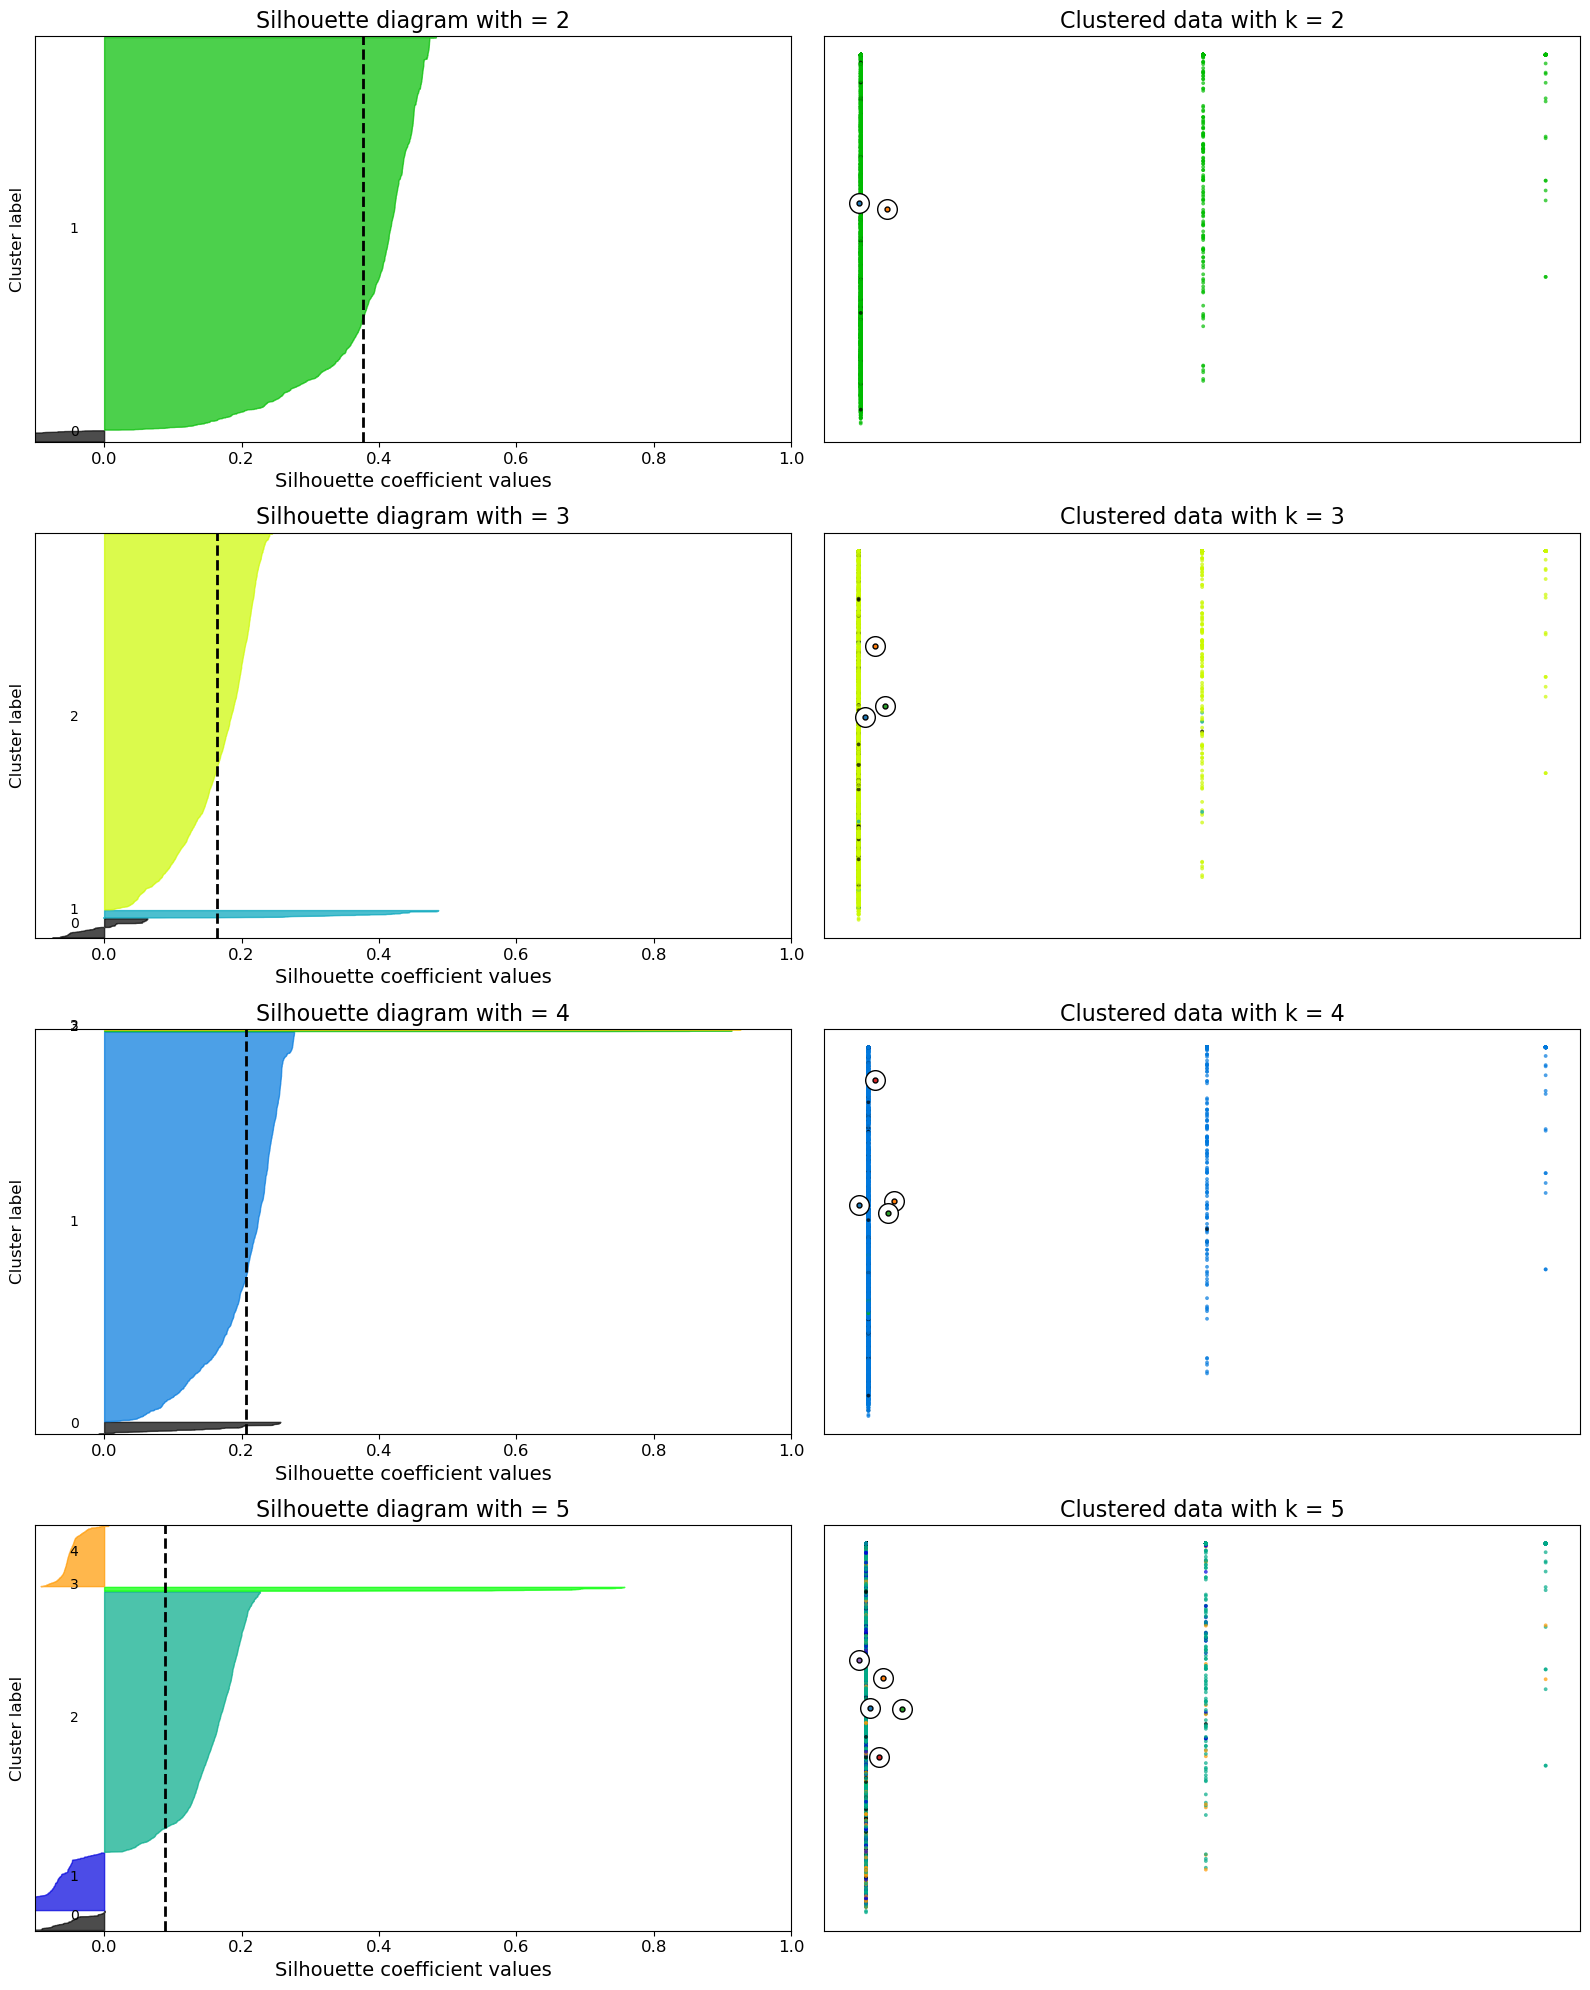

In [326]:
# method 3 silhouette diagram
range_n_clusters = [2,3,4,5]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))
for row, n_clusters in enumerate(range_n_clusters):

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(Xs_pca) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = kmeans_k[n_clusters-2].predict(Xs_pca)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed clusters
  silhouette_avg = silhouette_score(Xs_pca, cluster_labels)
  print("For n_clusters =", n_clusters, ", the average silhouette_score is :", silhouette_avg)
  
  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(Xs_pca, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)
  
  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  ## right side of chart
  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(Xs[:, 0], Xs[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
  
  # Labeling the clusters
  centers = kmeans_k[n_clusters-2].cluster_centers_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
  
  for i, c in enumerate(centers):
    #ax[row, 1].scatter(c[0], c[1], marker=' '% i, alpha=1,s=50, edgecolor='k')
    ax[row, 1].scatter(c[0], c[1], marker='.', alpha=1,s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("", fontsize=14)
  ax[row, 1].set_ylabel("", fontsize=14)
  ax[row, 1].set_yticks([]) 
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "with = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
#plt.savefig("silhouette_diagram.png", dpi=650, transparent=False)
plt.show()
     

In [327]:
# best number of clusters 
N=4
kmeans = KMeans(n_clusters=N, random_state=0).fit(Xs)
labs=kmeans.labels_

In [329]:
#2d plot
test2d = X_pca.loc[:,["pca 1","pca 2"]]
test2d['cluster'] = labs
fig = px.scatter(test2d, x="pca 1", y="pca 2", color='cluster')
fig.show()

In [330]:
# 3d plot
test3d=X_pca.loc[:,["pca 1","pca 2","pca 3"]]
test3d["cluster"]=labs

fig = px.scatter_3d(
    test3d, x='pca 1', y='pca 2', z='pca 3', color='cluster',
    title='K-Clusters',
)
fig.show()

## 3.2 Hierarchical Clustering (TODO)

In [331]:
import warnings
warnings.filterwarnings('ignore')

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 

HC : more used in NLP, unstructured data analysis

1. top down :  Divisive Hierachical Clustering (HDC),also called DIANA (Divisive ANAlysis). 1 cluster -> N clusters. More complex, more efficient, do not need to specify the number of clusters.
2. bottom up: Hierachical Agglomerative Clustering (HAC). Each observation starts in its own clusters -> N clusters

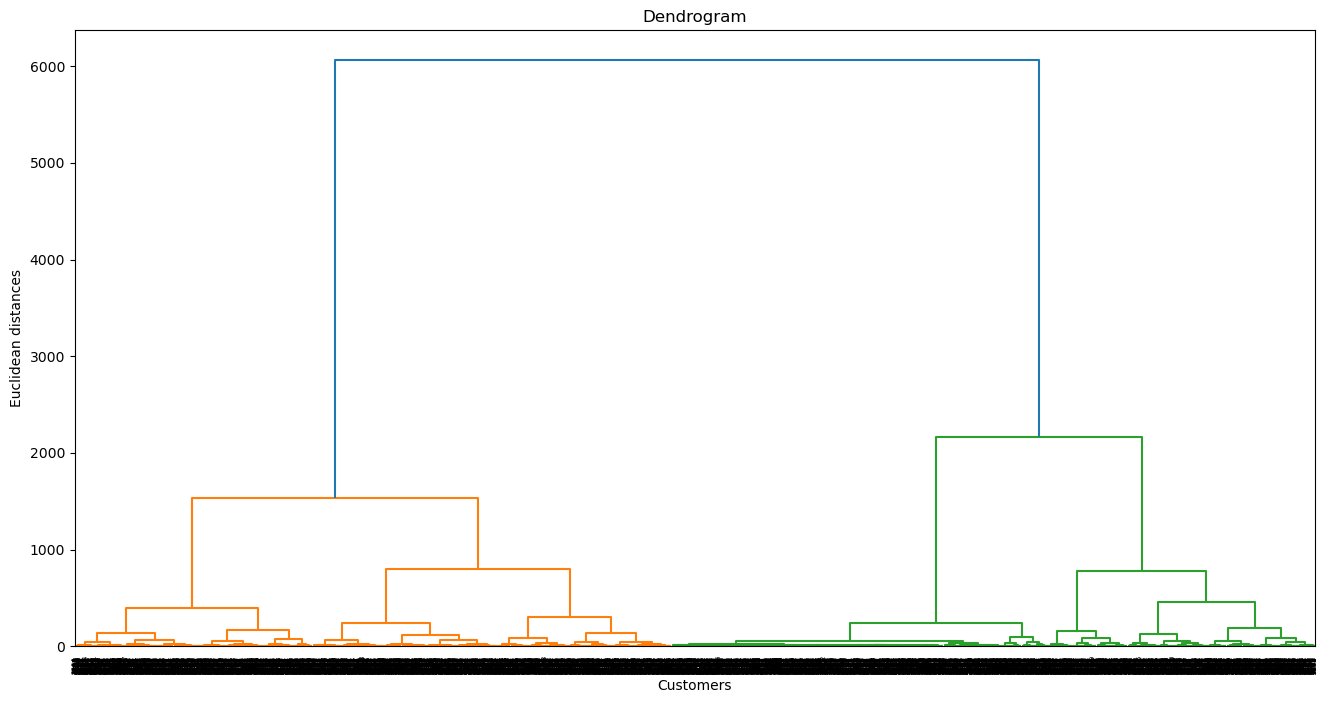

In [341]:
# top down
plt.figure(1, figsize = (16 ,8))
dendrogram = sch.dendrogram(sch.linkage(X_samples, method  = "ward"))
#dendrogram = sch.dendrogram(sch.linkage(Xs_pca, method  = "ward"))

plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [342]:
# bottoms up
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='average')

y_hc = hc.fit_predict(X_samples)
#y_hc = hc.fit_predict(X_pca)
cluster = pd.DataFrame(y_hc)
cluster.value_counts()

1    1920
2    1894
0    1218
3     968
dtype: int64

In [343]:
trace1 = pgo.Scatter3d(
    x= X_samples['total_spend'], y= X_samples['basket_size'], z= X_samples['orders'],
    mode='markers',
    marker=dict(
        color = cluster,
        size= 6,
        line=dict(
            color= cluster,
            width= 12
        ),
        opacity=0.8
    )
)
data = [trace1]
layout = pgo.Layout(
    title= 'Clusters using Agglomerative Clustering',
    scene = dict(
            xaxis = dict(title  = 'total_spend'),
            yaxis = dict(title  = 'basket_size'),
            zaxis = dict(title  = 'orders')
        )
)
fig = pgo.Figure(data=data, layout=layout)
fig.show()

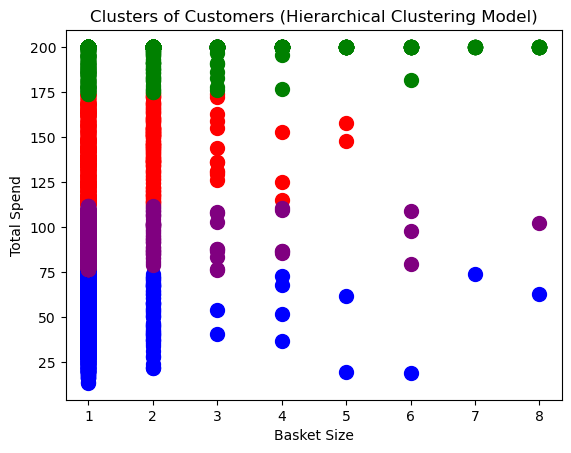

In [346]:
X = X_samples.iloc[:, [2,1]].values
plt.scatter(X[y_hc==0, 0], X[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_hc==1, 0], X[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_hc==2, 0], X[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_hc==3, 0], X[y_hc==3, 1], s=100, c='purple', label ='Cluster 4')
#plt.scatter(X[y_hc==4, 0], X[y_hc==4, 1], s=100, c='orange', label ='Cluster 5')
plt.title('Clusters of Customers (Hierarchical Clustering Model)')
plt.xlabel('Basket Size')
plt.ylabel('Total Spend')
plt.show()

# 4. Cluster Analysis


In [ ]:
import collections 

In [363]:
# best number of clusters is 3
N=4

# km based on scaled features from PCA
kmeans = KMeans(n_clusters=N, random_state=0).fit(Xs_pca)
km_labs = kmeans.labels_

# hc based on non scaled original features.
hc = AgglomerativeClustering(n_clusters = N, affinity = 'euclidean', linkage ='average')
hc_labs = hc.fit_predict(X_samples)

In [364]:
print('K-Means Clusters: {}'.format(collections.Counter(km_labs)))
print('HC Clusters: {}'.format(collections.Counter(hc_labs)))

K-Means Clusters: Counter({2: 4820, 0: 921, 3: 141, 1: 118})
HC Clusters: Counter({1: 1920, 2: 1894, 0: 1218, 3: 968})


In [349]:
customer_samples

,customer_unique_id,orders,total_spend,basket_size,product_categories,product_categories_en,payment_types,customer_state
90678,e93a61367ac4e23a645f96907cdfac70,1,119.94,1,informatica_acessorios,computers_accessories,boleto,SP
53288,891fda05c6f2315887eb933b15c4cde2,1,50.77,1,brinquedos,toys,credit_card,SP
23486,3c53714af64e0118badeb4ebc3fe300f,1,200.00,1,cama_mesa_banho,bed_bath_table,credit_card,RJ
50028,80768413a59684f1e4c68a4e85feac9d,1,99.90,1,relogios_presentes,watches_gifts,credit_card,ES
60525,9b994af54c6d32342fef79cf811d2e5a,1,50.00,1,pet_shop,pet_shop,credit_card,MG
...,...,...,...,...,...,...,...,...
26162,4348c924a0bc86f4a053fa7e3de73d87,1,119.45,1,moveis_decoracao,furniture_decor,credit_card,RN
25143,409b9ad422d4c4268bce0365f6e3fd38,1,200.00,1,beleza_saude,health_beauty,credit_card,SC
53889,8abc71015fc29ed9233e71a9c0bdb451,1,200.00,2,informatica_acessorios,computers_accessories,credit_card,PR
72216,b9a6cc06e014f28e0ecd1d8f5eb84ac8,1,56.60,1,instrumentos_musicais,musical_instruments,boleto,SP


In [365]:
# associate cluster label to customer data
customer_samples["km_cluster"]=km_labs
customer_samples["hc_cluster"]=hc_labs

In [351]:
def extract_pourcent(df,list_top3,var):
    dict_freq={}
    N=df.shape[0]
    for i in list_top3:
        d=df.loc[df[var]==i]
        n=d.shape[0]/N*100
        dict_freq[i]=round(n,1)
    return dict_freq

def most_pop(df, cluster_name, variable, cluster):
    d=df.loc[df[cluster_name]==cluster]
    cat_list=list(d[variable].values)
    cat_counter = {}
    for word in cat_list:
        if word in cat_counter:
            cat_counter[word] += 1
        else:
            cat_counter[word] = 1

    popular_cat = sorted(cat_counter, key = cat_counter.get, reverse = True)
    top_4 = popular_cat[:4]
    top_4=extract_pourcent(d,top_4,variable)
    return top_4

In [380]:
def cluster_analysis(df, cluster_name, N):
    for n_cluster in range(N):
        the_cluster=n_cluster
        cluster_size = df[cluster_name].value_counts()[n_cluster]
        top_dimensions = {
            'popular_cat':most_pop(df, cluster_name, "product_categories_en",the_cluster),
            'popular_state':most_pop(df, cluster_name, "customer_state",the_cluster),
            'popular_payment_type':most_pop(df, cluster_name, "payment_types",the_cluster),
            'popular_orders':most_pop(df, cluster_name, "orders",the_cluster)
        }
        dimensions = len(top_dimensions)
        dimensions_keys = list(top_dimensions.keys())
        
        fig=plt.figure(1,figsize=[19,5])
        fig.patch.set_facecolor('#E0E0E0')
        fig.patch.set_alpha(0.7)

        plt.suptitle("{}-{}: {} customers.".format(cluster_name, the_cluster, cluster_size),size=15)
        row = n_cluster+1
        for col in range(1, dimensions+1):
            plt.subplot(row,dimensions,col)
            plt.title(dimensions_keys[col-1])
            plt.bar(range(0,len(top_dimensions[dimensions_keys[col-1]])),top_dimensions[dimensions_keys[col-1]].values(),color="#a1c2cc",edgecolor='black')
            plt.xticks(range(0,len(top_dimensions[dimensions_keys[col-1]])),list(top_dimensions[dimensions_keys[col-1]].keys()),rotation=90)
            plt.ylabel("Percentage")

        plt.show()

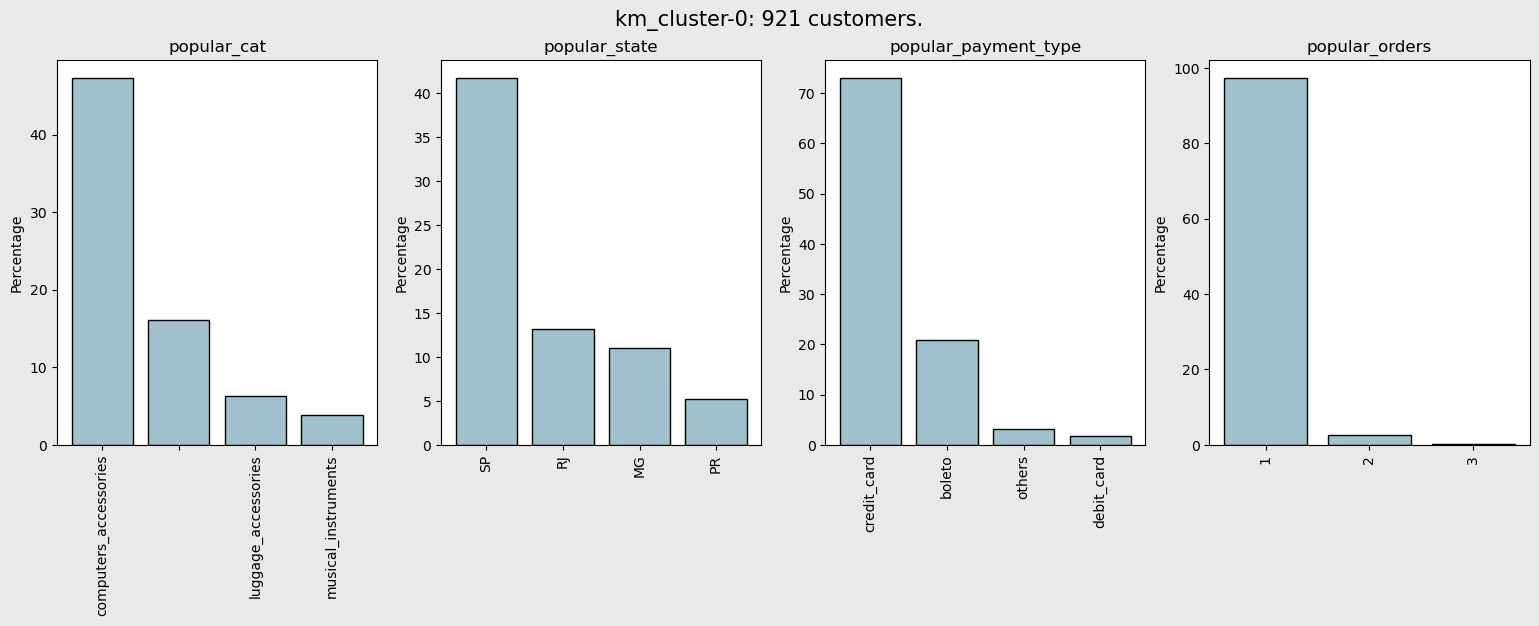

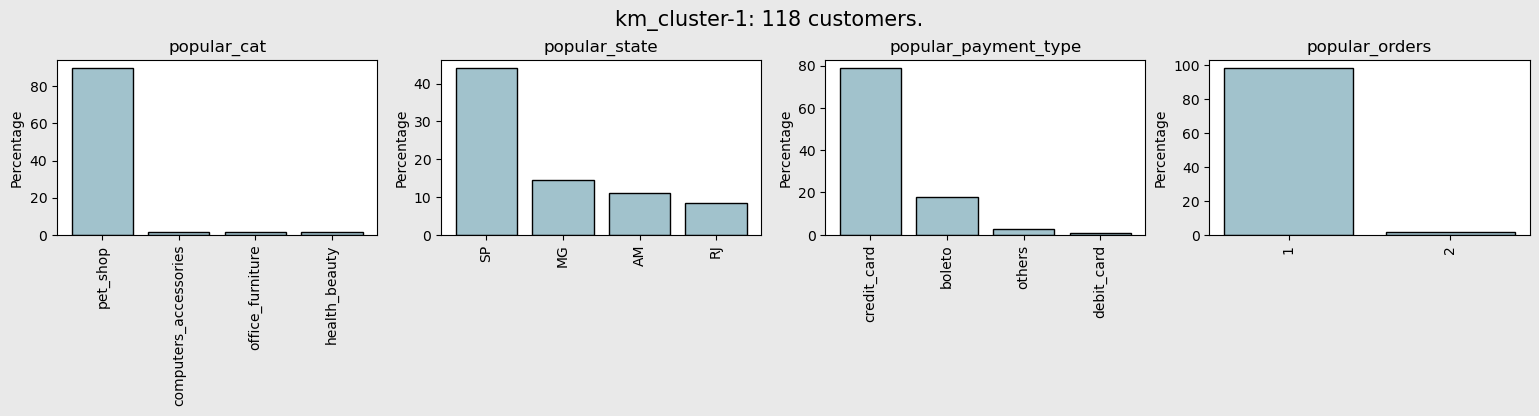

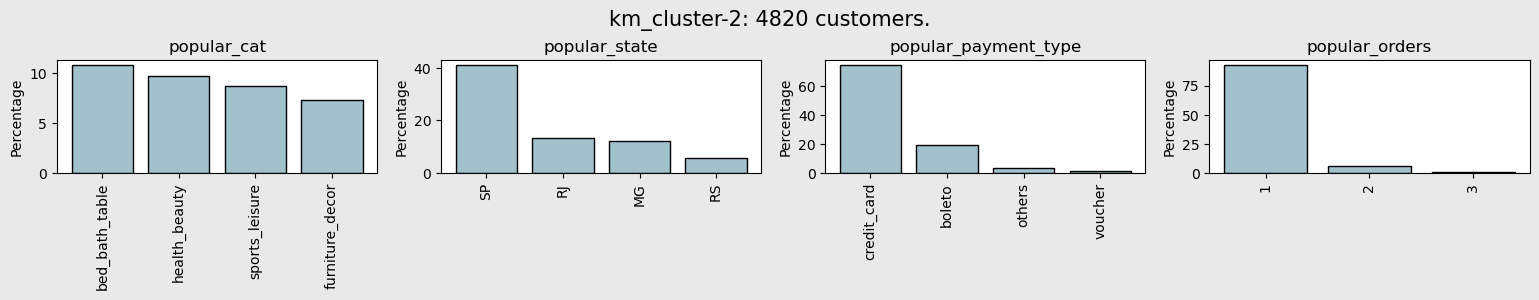

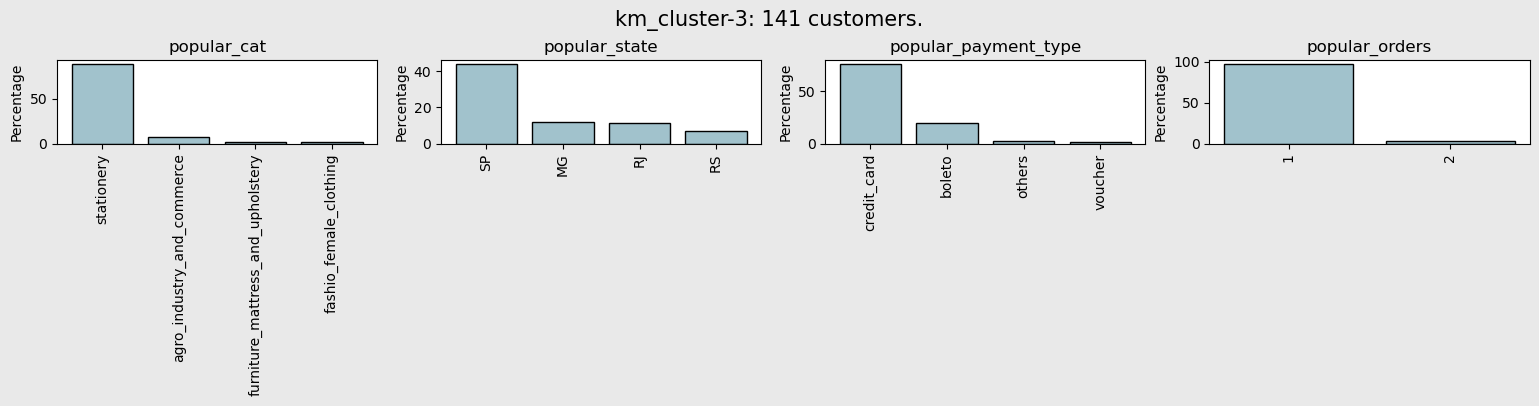

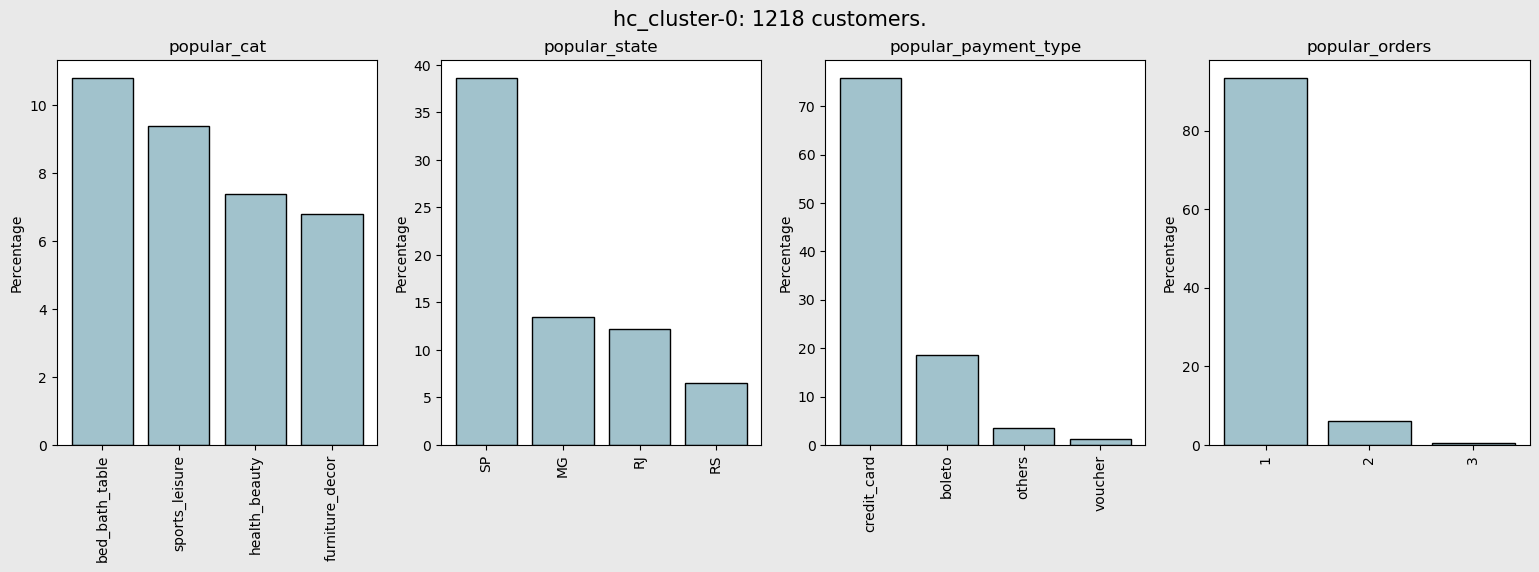

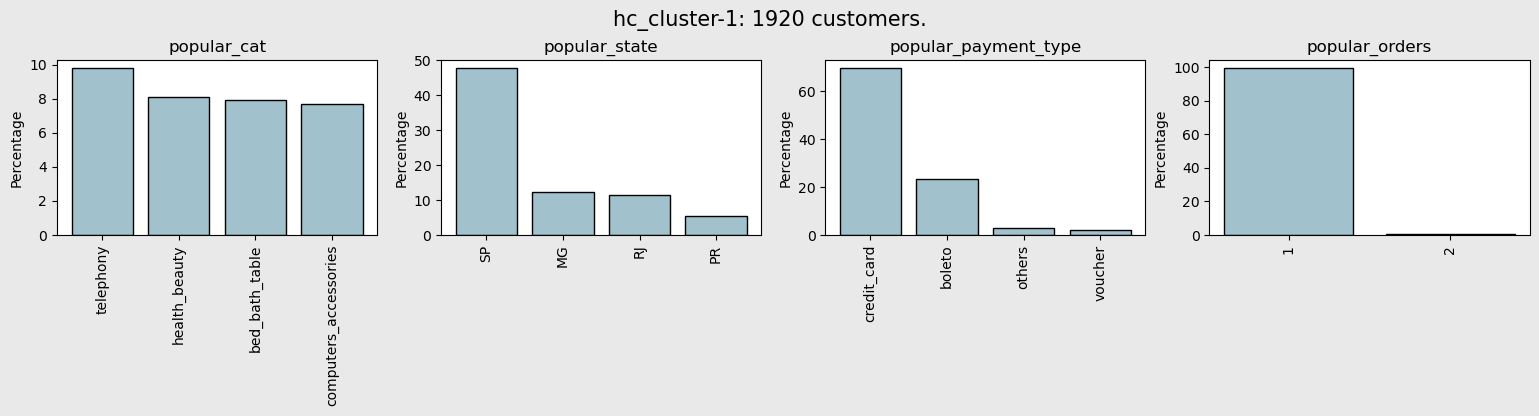

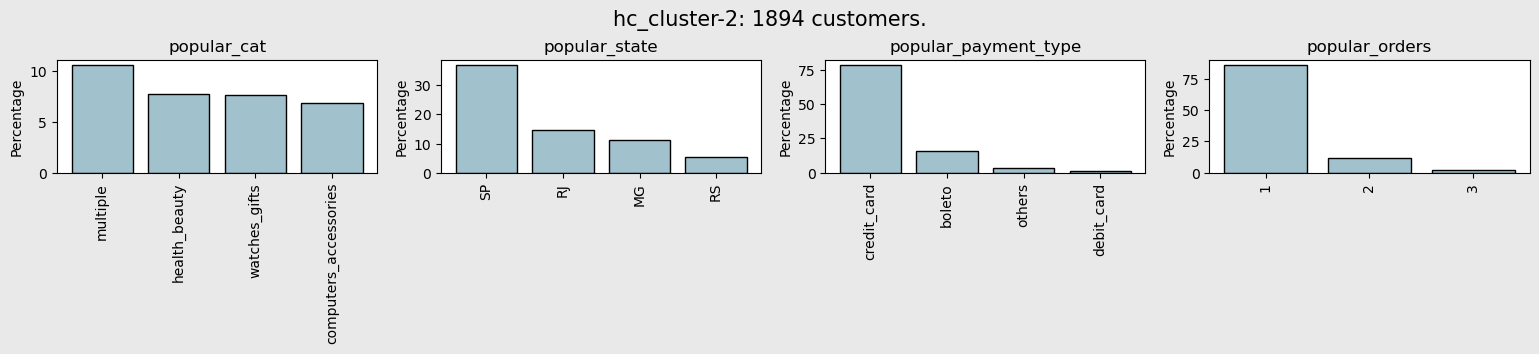

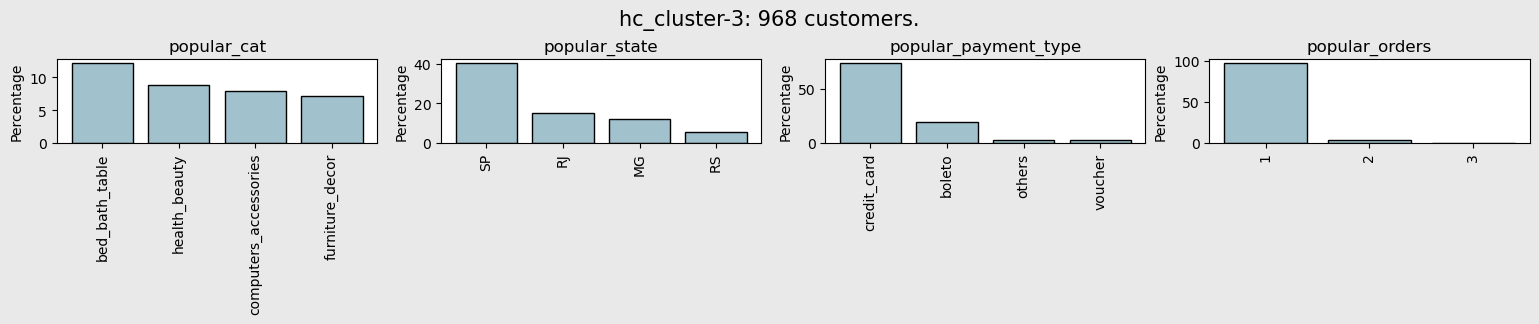

In [381]:
cluster_analysis(customer_samples, 'km_cluster',N)
cluster_analysis(customer_samples, 'hc_cluster',N)

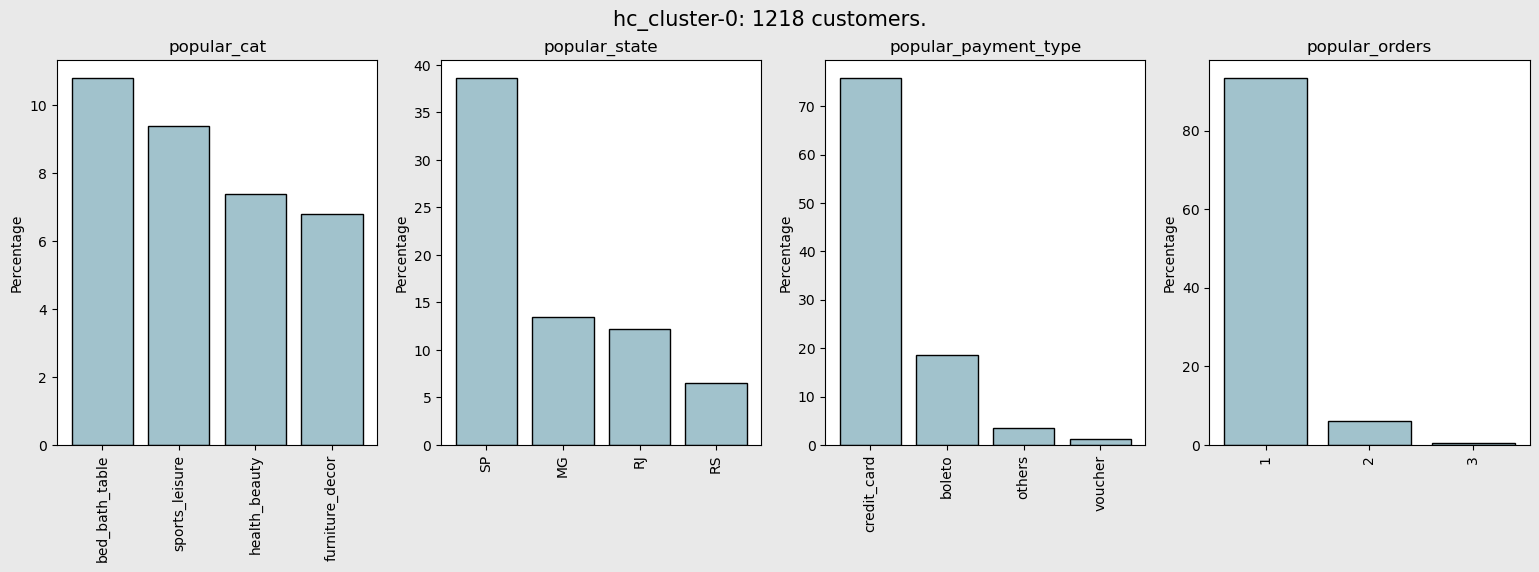

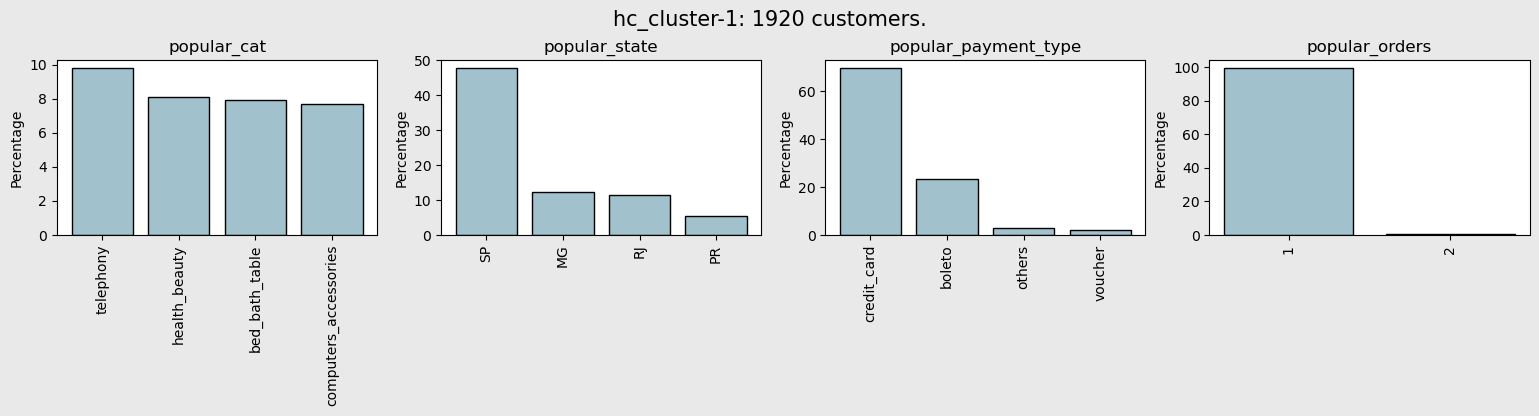

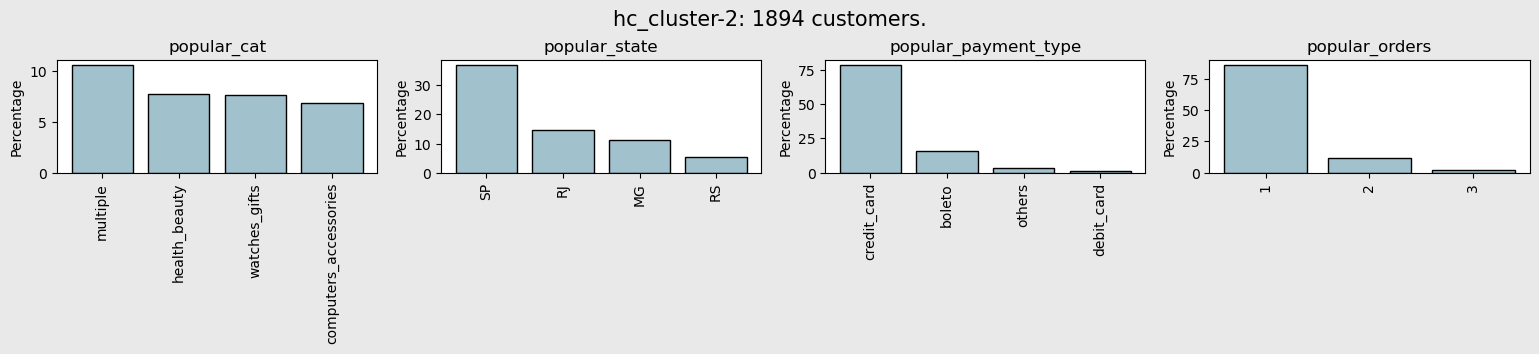

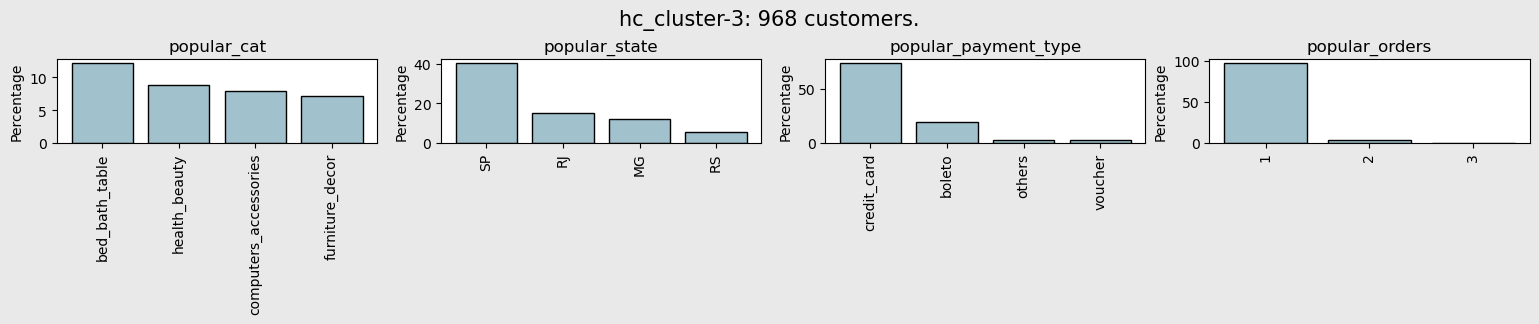

In [368]:
customer_samples.head()

,customer_unique_id,orders,total_spend,basket_size,product_categories,product_categories_en,payment_types,customer_state,km_cluster,hc_cluster,avg_spend
90678,e93a61367ac4e23a645f96907cdfac70,1,119.94,1,informatica_acessorios,computers_accessories,boleto,SP,0,0,119.94
53288,891fda05c6f2315887eb933b15c4cde2,1,50.77,1,brinquedos,toys,credit_card,SP,2,1,50.77
23486,3c53714af64e0118badeb4ebc3fe300f,1,200.00,1,cama_mesa_banho,bed_bath_table,credit_card,RJ,2,2,200.00
50028,80768413a59684f1e4c68a4e85feac9d,1,99.90,1,relogios_presentes,watches_gifts,credit_card,ES,2,3,99.90
60525,9b994af54c6d32342fef79cf811d2e5a,1,50.00,1,pet_shop,pet_shop,credit_card,MG,1,1,50.00


In [369]:
customer_samples['avg_spend']=customer_samples['total_spend']/customer_samples['basket_size']

<AxesSubplot:xlabel='hc_cluster', ylabel='avg_spend'>

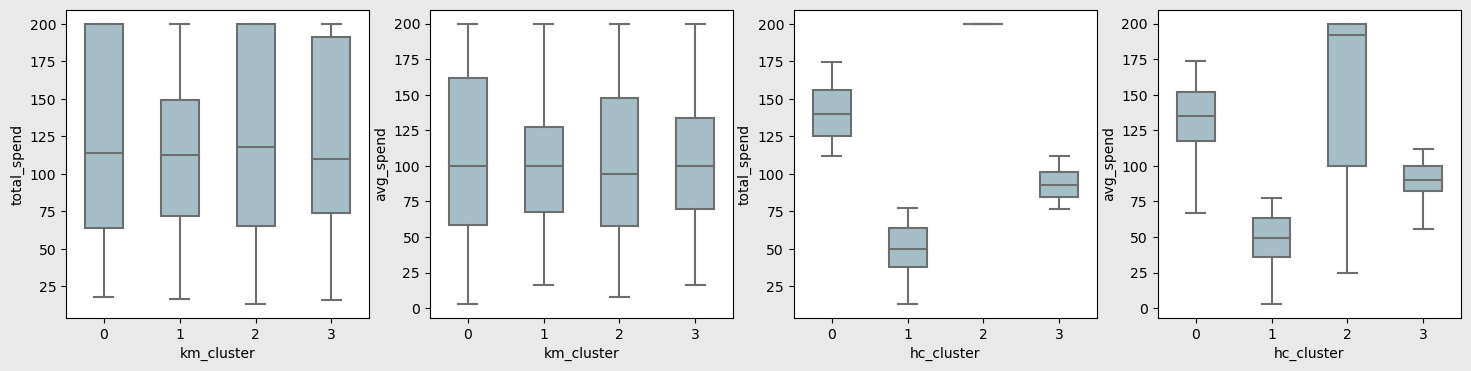

In [377]:
fig=plt.figure(1,figsize=[18,4])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.subplot(1,4,1)
sns.boxplot(data=customer_samples,x="km_cluster",y="total_spend",width=0.5,showfliers=False,color="#a1c2cc")
plt.subplot(1,4,2)
sns.boxplot(data=customer_samples,x="km_cluster",y="avg_spend",width=0.5,showfliers=False,color="#a1c2cc")
plt.subplot(1,4,3)
sns.boxplot(data=customer_samples,x="hc_cluster",y="total_spend",width=0.5,showfliers=False,color="#a1c2cc")
plt.subplot(1,4,4)
sns.boxplot(data=customer_samples,x="hc_cluster",y="avg_spend",width=0.5,showfliers=False,color="#a1c2cc")